## Final Project

### Student Name and ID :
Daya Meenakshi Bala Subbu (8964370), 
Bismi Poulose (8981107)
### Program Code: 
CSCN8010
### Program Name: 
Foundations of Machine Learning Frameworks


## Reference:
Dataset : https://www.kaggle.com/datasets/muhammadsaoodsarwar/drone-vs-bird/data


In [2]:
# Install necessary libraries
%pip install tensorflow keras matplotlib seaborn scikit-learn opencv-python


Note: you may need to restart the kernel to use updated packages.


## Step 1 - Data Preprocessing

The dataset has been prepared for training and validation. The dataset containing aerial images of drones and birds, and the goal is to classify whether an image contains a drone or a bird.

1. **Importing Libraries**: 
Essential libraries such as TensorFlow, NumPy, Matplotlib, and scikit-learn are imported for image processing, modeling, and evaluation.

2. **Setting the Dataset Path**: 
The base_dir points to the root directory where the dataset is stored. This directory should have two subfolders named bird and drone, representing the two classes.

3. **Creating ImageDataGenerators**:  
   - By using the ImageDataGenerator to normalize the image pixel values by scaling them to the range [0, 1] using rescale=1./255.  
   - The dataset is split into training and validation sets using the validation_split parameter.

4. **Preparing Training and Validation Sets**:  
   - `train_dataset` and `val_dataset` are created using `flow_from_directory`, which loads images directly from the directory, resizes them to 150x150 pixels, and assigns binary class labels (0 or 1).  
   - A batch size of 32 is used for efficient training.
   - Displaying the totel images in the train and validation set.
These datasets will now be used to train, validate, and evaluate the models in the next steps


In [ ]:
#The dataset has drone and bird images. Here, we are going to train model to classify the Aerial Objects which is drone opr bird.

#Step 1 - Data Preprocessing 
#Importing the required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

#Set paths
base_dir = "/Users/dayapankajam/Desktop/dataset/"

#Creating the ImageDataGenerators
train_set = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Splitting the original set into Training and validation dataset
train_dataset = train_set.flow_from_directory(base_dir, target_size=(150, 150), batch_size=32, class_mode='binary', subset='training')
val_dataset = train_set.flow_from_directory(base_dir, target_size=(150, 150), batch_size=32, class_mode='binary', subset='validation')



Found 3284 images belonging to 2 classes.
Found 820 images belonging to 2 classes.


In [4]:
#Displaying the total number 
print("Total training images:", train_dataset.n)
print("Total validation images:", val_dataset.n)

print("Number of classes:", train_dataset.num_classes)
print("Class indices:", train_dataset.class_indices)


Total training images: 3284
Total validation images: 820
Number of classes: 2
Class indices: {'bird': 0, 'drone': 1}


## Step 2 - Visualizing the Training Dataset

To visualize a batch of images from the training dataset to get an understanding of the data the model will learn from.

1. **Loading a Batch**:  
   Using `next(train_dataset)` retrieve one batch of images and their corresponding labels from the training generator.

2. **Plotting the Images**:  
   - We plot the first 12 images in a 4x3 grid using `matplotlib`.  
   - Each image is displayed with its respective label: "Drone" if the label is 1, otherwise "Bird".  
   - `plt.imshow()` is used to display each image, and `plt.title()` shows the class label.

This helps for visual inspection to ensure that the images and their labels are correctly loaded and can also help identify any issues in preprocessing or class distribution.


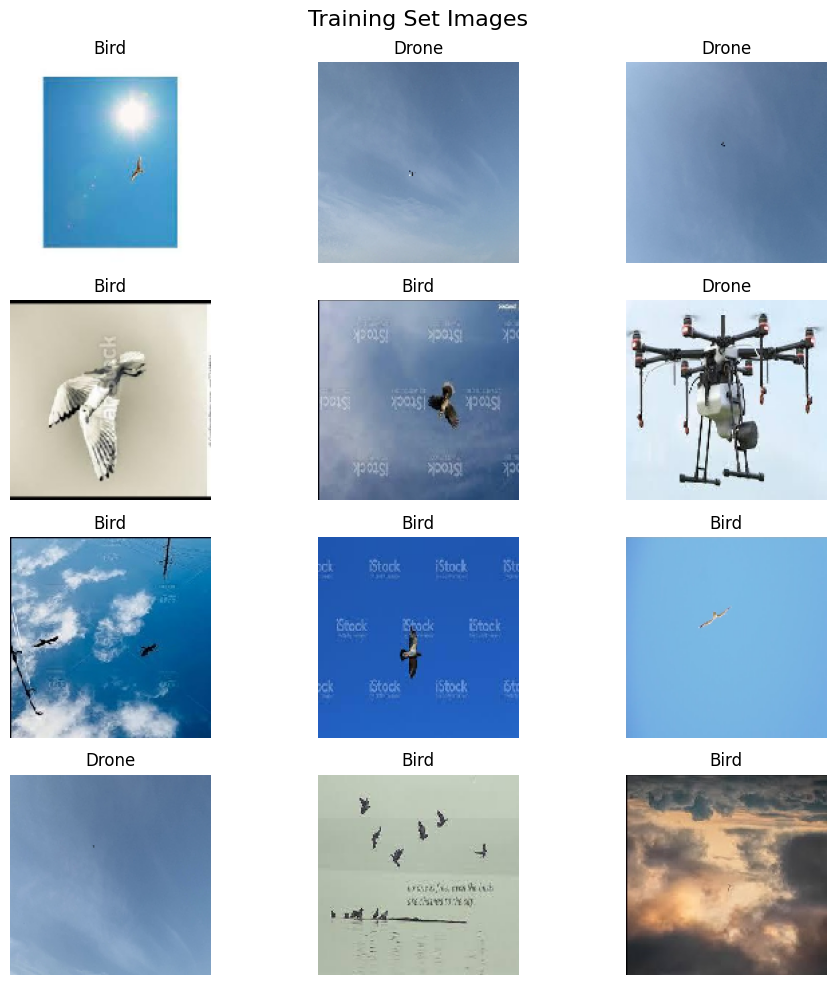

In [ ]:
#Step 2 - Train Dataset
#Getting a batch of training images and labels
images, labels = next(train_dataset)

#Plotting 12 sample images from the Training dataset
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.imshow(images[i])
    label = "Drone" if labels[i] == 1 else "Bird"
    plt.title(label)
    plt.axis('off')

plt.suptitle("Training Set Images", fontsize=16)
plt.tight_layout()
plt.show()


## Step 3 - Exploring Image Dimensions in the Training Set

 Analyze the dimensions especially width and height of all images in the dataset to understand the variability in image sizes across the two categories: **bird** and **drone**.

1. **Image Size Extraction**:  
   - Iterate through both folders (`bird` and `drone`) inside the base directory.  
   - For each image, we use the `PIL.Image` library to extract its width and height.  
   - All extracted dimensions are stored in a list as dictionaries with an associated category label.
   - We convert the list of dictionaries into a Pandas DataFrame (`dims_df`) for easier manipulation and visualization.
2. **Visualization**:  
   - Using `seaborn.lineplot`, we plot a comparison of width and height distributions for images in both categories.  
   - This helps to identify if there's a significant variation in image sizes, which is useful for preprocessing decisions such as resizing.
This analysis ensures the dataset is consistent and helps us choose appropriate input dimensions for our neural network.


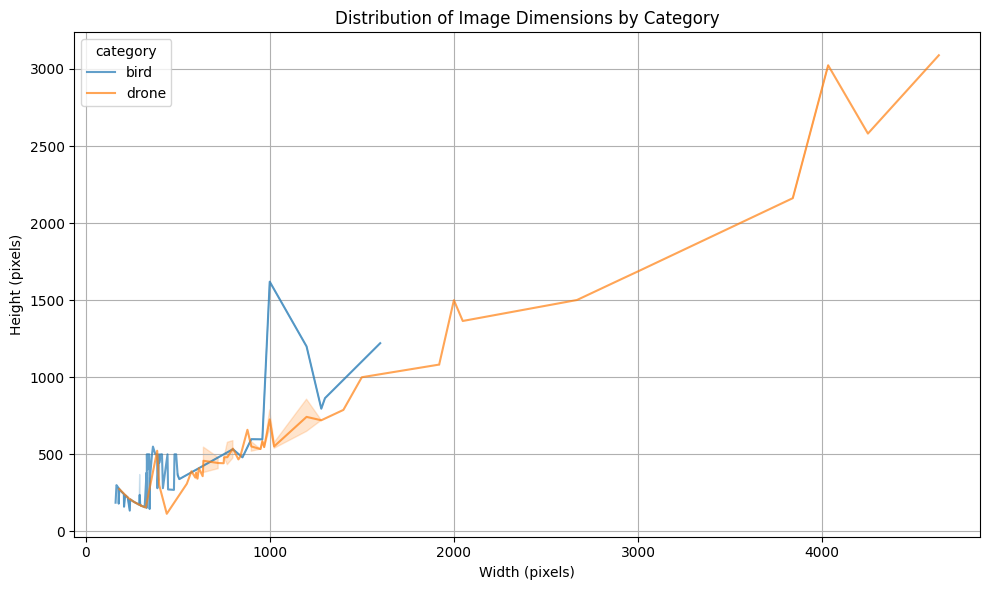

In [ ]:
#Step 3 - Plot the graph for dimensions in train set
from PIL import Image
import os
import seaborn as sns
import pandas as pd

#Set path to training images for bird or drone
train_path = os.path.join(base_dir, 'bird')  
all_dims = []

#Iteration through both categories: bird and drone
for category in ['bird', 'drone']:
    category_path = os.path.join(base_dir, category)
    for img_file in os.listdir(category_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(category_path, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    all_dims.append({'width': width, 'height': height, 'category': category})
            except:
                print(f"Failed to open {img_path}")

#Converting into the DataFrame for easy plotting
dims_df = pd.DataFrame(all_dims)

#Plotting width and height distribution
plt.figure(figsize=(10, 6))
sns.lineplot(data=dims_df, x='width', y='height', hue='category', alpha=0.7)
plt.title('Distribution of Image Dimensions by Category')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 4 - Applying the CNN Model

To define and compile a Convolutional Neural Network (CNN) to classify aerial objects as either **drone** or **bird**.

### Model Architecture:
- **Input Layer**: Accepts RGB images of size 150x150.
- **Convolutional Layers**:  
  - Three convolutional layers with increasing filter sizes (32, 64, 128), each followed by a MaxPooling layer.  
  - These layers help the model learn spatial hierarchies of features from the images.
- **Flatten Layer**: Converts the 2D feature maps into a 1D vector.
- **Fully Connected Layers**:  
  - A dense layer with 128 neurons and ReLU activation.  
  - A dropout layer 50% is added to prevent overfitting.
- **Output Layer**: A single neuron with sigmoid activation to output binary classification (0 = Bird, 1 = Drone).

### Compilation:
- **Optimizer**: `Adam` – an adaptive optimizer suitable for deep learning tasks.
- **Loss Function**: `binary_crossentropy` – appropriate for binary classification.
- **Evaluation Metric**: `accuracy` – to track how often predictions match the labels.

The CNN model is now ready to be trained on the preprocessed dataset.


In [7]:
#Step 4 - Applying the CNN Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input(shape=(150, 150, 3)), Conv2D(32, (3, 3), activation='relu'),MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'), MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),MaxPooling2D(pool_size=(2, 2)),
    Flatten(), Dense(128, activation='relu'),
    Dropout(0.5),Dense(1, activation='sigmoid')
])

#Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Displaying the model architecture summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5 - Training and storing the CNN Model

Trainig the CNN model using the training and validation datasets over **10 epochs**. During training, the model learns to differentiate between drone and bird images based on the features it extracts from the convolutional layers.

### Training Process:
- **Training Dataset**: Used to train the model weights.
- **Validation Dataset**: Used to evaluate the model performance after each epoch and prevent overfitting.

After the training process, the trained model is saved to a file named **`final_model.h5`**, which can be loaded later for evaluation or deployment. The message printed says "Best model saved as 'final_model.h5'. 


In [ ]:
cnn_history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)
model.save('final_model.h5')
print("Best model saved as 'final_model.h5'.")

/Users/dayapankajam/CSCN8010-lab-submissions/.conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - accuracy: 0.6818 - loss: 0.6750 - val_accuracy: 0.7171 - val_loss: 0.5620
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 402ms/step - accuracy: 0.8328 - loss: 0.3751 - val_accuracy: 0.7146 - val_loss: 0.5453
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 386ms/step - accuracy: 0.8757 - loss: 0.2983 - val_accuracy: 0.7793 - val_loss: 0.3943
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.9182 - loss: 0.1792 - val_accuracy: 0.8024 - val_loss: 0.5066
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.9373 - loss: 0.1452 - val_accuracy: 0.8000 - val_loss: 0.3838
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 412ms/step - accuracy: 0.9612 - loss: 0.1204 - val_accuracy: 0.8012 - val_loss: 0.7581
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 395ms/step - accuracy: 0.9521 - loss: 0.1182 - val_accuracy: 0.6841 - val_loss: 0.7693
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 43s 414ms/step - accuracy: 0.9713 - loss: 0

Best model saved as 'best_model.h5'.


## Step 6 - Visualizing Training Performance and Model Evaluation

Visualizing the training progress and evaluate the CNN model on the validation dataset.

### Training Visualization
- **Accuracy Plot**: Shows how well the model performs on training vs. validation data.
- **Loss Plot**: Helps understand how well the model is minimizing error over epochs.

These plots give insights into whether the model is underfitting, overfitting, or training effectively.

### Evaluation Metrics
- **Confusion Matrix**: Displays the number of correct and incorrect predictions for each class (Bird and Drone).
- **Classification Report**: Provides precision, recall, F1-score, and support for both classes.

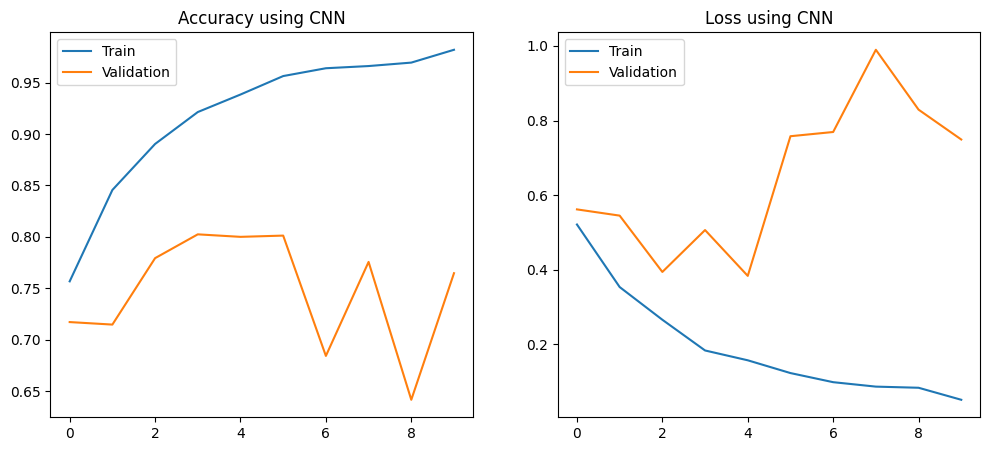

In [ ]:
# Step 6 - Visualizing Training Performance and evaluations

plt.figure(figsize=(12, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train')
plt.plot(cnn_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy using CNN')
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.title('Loss using CNN')
plt.legend()
plt.show()


### Insights

- **Training accuracy** shows a consistent upward trend, nearing 100%, which indicates strong learning on the training dataset.
- **Validation accuracy**, however, remains inconsistent and fluctuates after initial improvement, suggesting the model is struggling to generalize well.
- **Training loss** steadily decreases, confirming effective optimization on training data.
- **Validation loss** increases after a few epochs, which is a clear sign of **overfitting**.


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
[[129 192]
 [213 286]]
              precision    recall  f1-score   support

        Bird       0.38      0.40      0.39       321
       Drone       0.60      0.57      0.59       499

    accuracy                           0.51       820
   macro avg       0.49      0.49      0.49       820
weighted avg       0.51      0.51      0.51       820



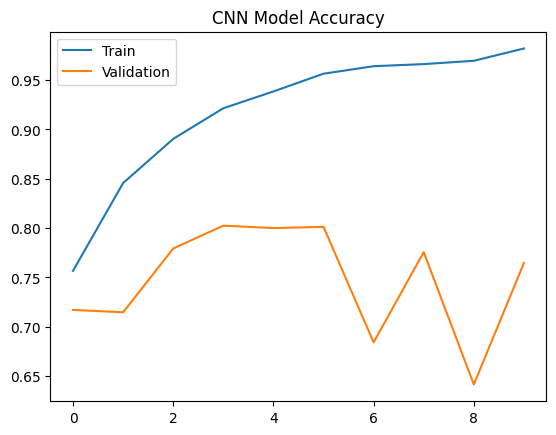

In [10]:
#Evaluation and Metrics

#Confusion Matrix
val_dataset.reset()
preds_cnn = (model.predict(val_dataset) > 0.5).astype("int32")
true_labels = val_dataset.classes
print(confusion_matrix(true_labels, preds_cnn))
print(classification_report(true_labels, preds_cnn, target_names=['Bird', 'Drone']))
#Accuracy plots
plt.plot(cnn_history.history['accuracy'], label='Train')
plt.plot(cnn_history.history['val_accuracy'], label='Validation')
plt.title('CNN Model Accuracy')
plt.legend()
plt.show()


#### CNN Model Insights:
- The Training accuracy for CNN steadily increases and approaches nearly 100%, indicating the model is learning the training data properly.
- The validation accuracy for CNN fluctuates and shows early signs of stagnation and inconsistency after a few epochs, which may suggest **overfitting**.
- The training loss continuously decreases, showing effective minimization on the training set.
- However the validation loss increases after a certain point, reinforcing the sign of overfitting — the model performs well on training data but generalizes poorly to unseen data.
- This behavior suggests that hyperparameter tuning might be necessary to improve generalization.


## Step 7 - Hyperparameter Tuning Using VGG16 (Transfer Learning)

Leverage **VGG16**, a pre-trained convolutional neural network, to enhance our model's performance through **transfer learning**.

### Key Actions:
- **Loaded VGG16 without top layers** (`include_top=False`) and with `imagenet` weights.
- **Froze the convolutional base** so only the top classifier layers are trainable.
- **Added custom top layers** including `GlobalAveragePooling2D`, a dense layer with ReLU activation, a dropout for regularization, and a final output layer using the sigmoid activation function (for binary classification).

### Compilation and Training:
- Compiled with the **Adam** optimizer and **binary crossentropy** as the loss function.
- Trained for 10 epochs using the previously defined training and validation datasets.


In [ ]:
#Step 7 - Hyperparameter Tuning - VGG16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

#Loading VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

#Freezing the convolutional base
for layer in base_model.layers:
    layer.trainable = False

#Adding the classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

#Creating and compiling the model
vgg_model = Model(inputs=base_model.input, outputs=predictions)
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the VGG16 model
vgg_history = vgg_model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.7394 - loss: 0.5158 - val_accuracy: 0.8439 - val_loss: 0.4320
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9113 - loss: 0.2598 - val_accuracy: 0.8671 - val_loss: 0.3737
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9219 - loss: 0.2004 - val_accuracy: 0.9012 - val_loss: 0.3229
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9348 - loss: 0.1616 - val_accuracy: 0.8537 - val_loss: 0.3546
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9480 - loss: 0.1393 - val_accuracy: 0.9024 - val_loss: 0.2891
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9513 - loss: 0.1321 - val_accuracy: 0.8841 - val_loss: 0.3106
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9597 - loss: 0.1089 - val_accuracy: 0.9049 - val_loss: 0.2822
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9540 - loss: 0.1216 - val_accu

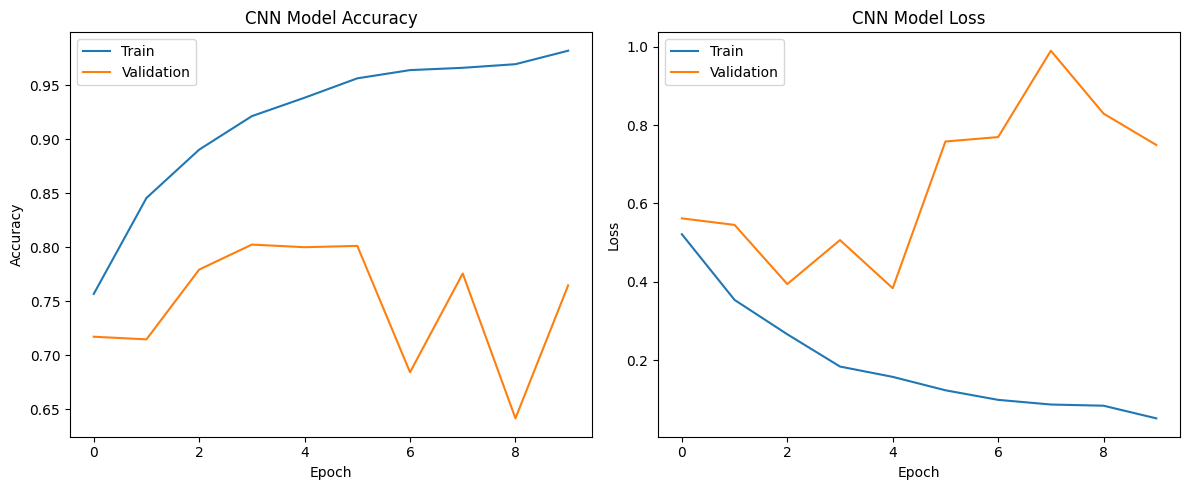

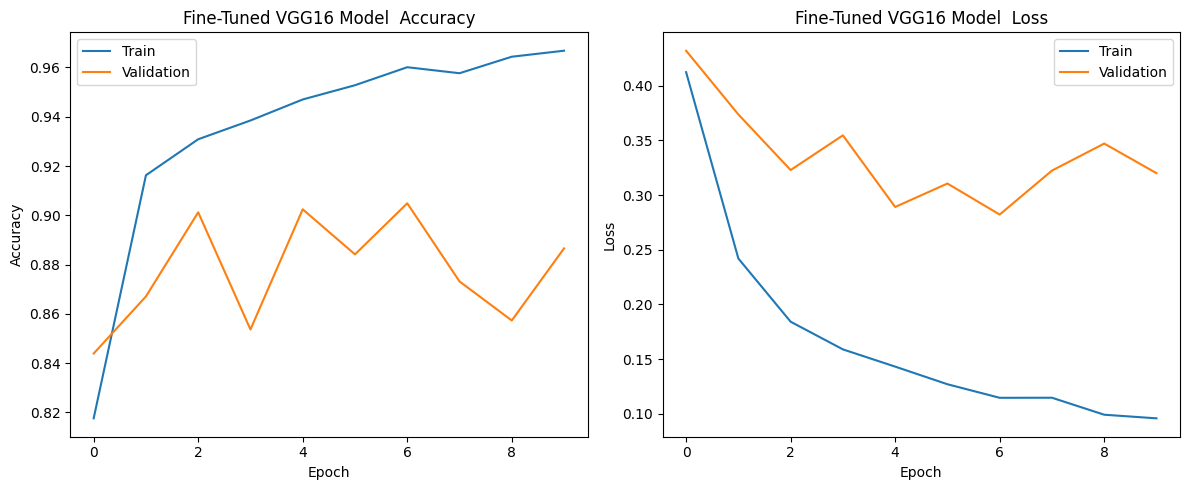

CNN Accuracy: 0.7646, Loss: 0.7492
VGG16 Accuracy: 0.8866, Loss: 0.3201


In [ ]:
#Step 8 - Comparing and Evaluating both the models using the Accuracy and loss

import matplotlib.pyplot as plt

def plot_model_history(history, title):
    plt.figure(figsize=(12, 5))
    #Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
#Displaying both the models for a comparison
plot_model_history(cnn_history, "CNN Model")
plot_model_history(vgg_history, "Fine-Tuned VGG16 Model ")

#Evaluating the CNN and VGG16
cnn_evaluation = model.evaluate(val_dataset, verbose=0)
print(f"CNN Accuracy: {cnn_evaluation[1]:.4f}, Loss: {cnn_evaluation[0]:.4f}")
vgg_evaluation = vgg_model.evaluate(val_dataset, verbose=0)
print(f"VGG16 Accuracy: {vgg_evaluation[1]:.4f}, Loss: {vgg_evaluation[0]:.4f}")


#### Insights:
The above plots show the training and validation **accuracy** and **loss** curves for both the **CNN model** and the **fine-tuned VGG16 model** over 10 epochs.

#### CNN Model:
- **Final Validation Accuracy:** 0.7646
- **Final Validation Loss:** 0.7492
- The model shows a high training accuracy but fluctuating validation performance, suggesting possible overfitting.
- Validation loss increases after a few epochs, while training loss continues to decrease, reinforcing the overfitting observation.

#### VGG16 Model:
- **Final Validation Accuracy:** 0.8866
- **Final Validation Loss:** 0.3201
- The VGG16 model generalizes better with smoother and more stable accuracy and loss curves across epochs.
- Training and validation metrics are closely aligned, indicating better model reliability and reduced overfitting.

- **Using VGG16 significantly improved performance**, achieving higher accuracy and lower loss than the custom CNN.
- This highlights the effectiveness of reusing learned features from a pre-trained model, especially when working with limited data.


## Step 9 - Fine-Tuning and Evaluating MobileNetV2

### Model Setup and Training

Implemented MobileNetV2 model using transfer learning.
- Loaded MobileNetV2 without its top layers (`include_top=False`) and froze the convolutional base.
- Added a Global Average Pooling layer, a Dense(64) hidden layer with ReLU activation, and a Dense(1) output layer with sigmoid activation for binary classification.
- Compiled and trained the model for 5 epochs using the same dataset for consistency.

### Evaluation and Results

After training, we predicted on the validation set and converted the sigmoid outputs to binary class predictions using a 0.5 threshold.
**Note:** Predictions were compared against true labels to evaluate the performance of the MobileNetV2 model.

- MobileNetV2 is known for being computationally efficient and mobile-friendly, making it suitable for real-time and resource-constrained applications.
- While it may not always outperform heavier models like VGG16 in accuracy, it often achieves a **better trade-off between speed and performance**.

### Conclusion:
- All three models were successfully implemented and evaluated.
- VGG16 showed the highest validation accuracy, while MobileNetV2 offered efficiency with competitive performance.
- The choice between these models can be based on use-case needs: VGG16 for accuracy, MobileNetV2 for efficiency, and CNN for customization.


In [ ]:
#Step 9 - Load and fine-tune MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#Loading the base model
base_model_mobilenet = MobileNetV2(include_top=False, input_shape=(150, 150, 3), weights='imagenet')
base_model_mobilenet.trainable = False  # Freeze base layers initially

#Adding the custom layers for Mobilenet model
x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model_mobilenet.input, outputs=predictions)

# Compile
mobilenet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
mobilenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5)


/var/folders/wb/j7v38d7n2v16fkyd7lcx1l_r0000gn/T/ipykernel_1217/2880543866.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(include_top=False, input_shape=(150, 150, 3), weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - accuracy: 0.8701 - loss: 0.3007 - val_accuracy: 0.8061 - val_loss: 0.4568
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 33s 323ms/step - accuracy: 0.9745 - loss: 0.0664 - val_accuracy: 0.8537 - val_loss: 0.3602
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - accuracy: 0.9861 - loss: 0.0385 - val_accuracy: 0.8427 - val_loss: 0.4054
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 338ms/step - accuracy: 0.9946 - loss: 0.0187 - val_accuracy: 0.8780 - val_loss: 0.3692
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 343ms/step - accuracy: 0.9950 - loss: 0.0150 - val_accuracy: 0.8122 - val_loss: 0.5551


In [17]:
#Evaluate and comparing all three models 

#Reset generator before looping
val_dataset.reset()

#Extracting the images and labels
all_images = []
all_labels = []

for i in range(len(val_dataset)):
    imgs, lbls = val_dataset[i]
    all_images.extend(imgs)
    all_labels.extend(lbls)

#Converting to NumPy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels).flatten()

#Predicting on validation data
mobilenet_preds = mobilenet_model.predict(all_images, batch_size=32)
y_predict_mobilenet = (mobilenet_preds > 0.5).astype("int32").flatten()


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step


## Step 10 - Accuracy Comparison and Confusion Matrix Analysis

To evaluate and compare the classification performance of the three models (CNN, VGG16, and MobileNetV2), we computed their accuracy on the validation dataset and visualized their respective confusion matrices.

### Accuracy Scores
**Model     | Validation Accuracy**

CNN         | 76.4%              
VGG16       | 88.6%              
MobileNetV2 | 81.2%       

- **VGG16** outperformed both CNN and MobileNetV2 in terms of accuracy, showcasing superior generalization.
- **MobileNetV2** achieved a balance between performance and speed, making it a good choice for mobile-friendly or real-time applications.
- **CNN**, being a custom model, performed the least accurately, possibly due to fewer layers and lack of pretrained features.

### Insights
- Pretrained models (VGG16 and MobileNetV2) significantly improves performance over a basic CNN.
- VGG16 is the best-performing model overall in this use case.
- Model choice depends on the trade-off between accuracy and computational efficiency, especially in deployment environments.

In [ ]:
# Step 10 - Accuracy and Confusion matrix for all three models by comparing them.
# Reset the iterator before extracting data
val_dataset.reset()

# Extract all images and labels
all_images = []
y_true_label = []

for i in range(len(val_dataset)):
    imgs, labels = val_dataset[i]
    all_images.extend(imgs)
    y_true_label.extend(labels)

#Converting to NumPy arrays
all_images = np.array(all_images)
y_true_label = np.array(y_true_label).flatten()

#CNN predictions
y_predict_cnn = (model.predict(all_images) > 0.5).astype("int32").flatten()

#VGG16 predictions
y_predict_vgg = (vgg_model.predict(all_images) > 0.5).astype("int32").flatten()

#MobileNet predictions
y_predict_mobilenet = (mobilenet_model.predict(all_images) > 0.5).astype("int32").flatten()

#Accuracy
from sklearn.metrics import accuracy_score
acc_cnn = accuracy_score(y_true_label, y_predict_cnn)
acc_vgg = accuracy_score(y_true_label, y_predict_vgg)
acc_mobilenet = accuracy_score(y_true_label, y_predict_mobilenet)
print("CNN Accuracy:", acc_cnn)
print("VGG16 Accuracy:", acc_vgg)
print("MobileNetV2 Accuracy:", acc_mobilenet)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step
CNN Accuracy: 0.7646341463414634
VGG16 Accuracy: 0.8865853658536585
MobileNetV2 Accuracy: 0.8121951219512196


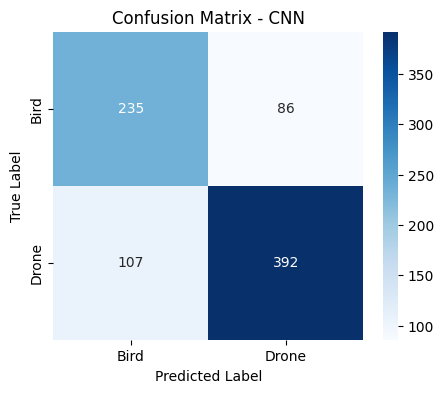

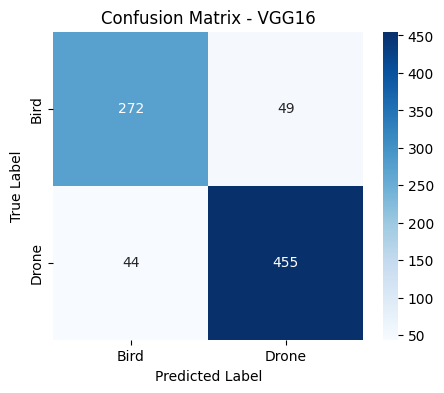

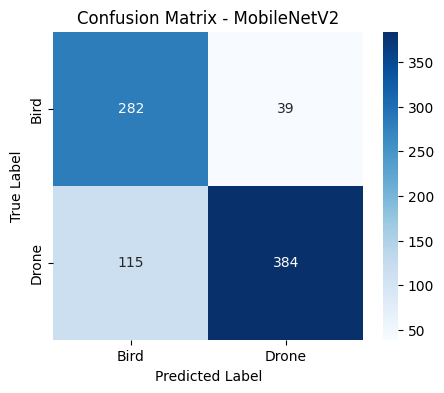

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

#Plotting the confusion matrix for all three models
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bird', 'Drone'], yticklabels=['Bird', 'Drone'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_true_label, y_predict_cnn, "Confusion Matrix - CNN")
plot_conf_matrix(y_true_label, y_predict_vgg, "Confusion Matrix - VGG16")
plot_conf_matrix(y_true_label, y_predict_mobilenet, "Confusion Matrix - MobileNetV2")



## Step 11 - Visualizing Misclassified Images

Display a sample of misclassified images from the validation dataset for each of the three models: **CNN**, **VGG16**, and **MobileNetV2**.

### Observations from the Misclassified Images

#### CNN
- The custom CNN model misclassified many images where **the object might be distant, partially visible, or blurred**.
- This indicates that the model may not have learned **robust feature representations** for complex scenarios.
- It appears especially weak in distinguishing between birds in flight and distant drones.

#### VGG16
- Misclassifications are fewer and often involve **very subtle distinctions**.
- In several cases, the **true label is visually ambiguous**, and even a human observer might hesitate.
- The model performs very well, but errors seem to occur in edge cases like **low lighting or unusual angles**.

#### MobileNetV2
- Performs better than CNN but slightly worse than VGG16.
- Misclassifications tend to occur in images where **drone structure is minimal** or bird features are **not prominent**.
- Given its lightweight nature, the performance is **strong considering model efficiency**.


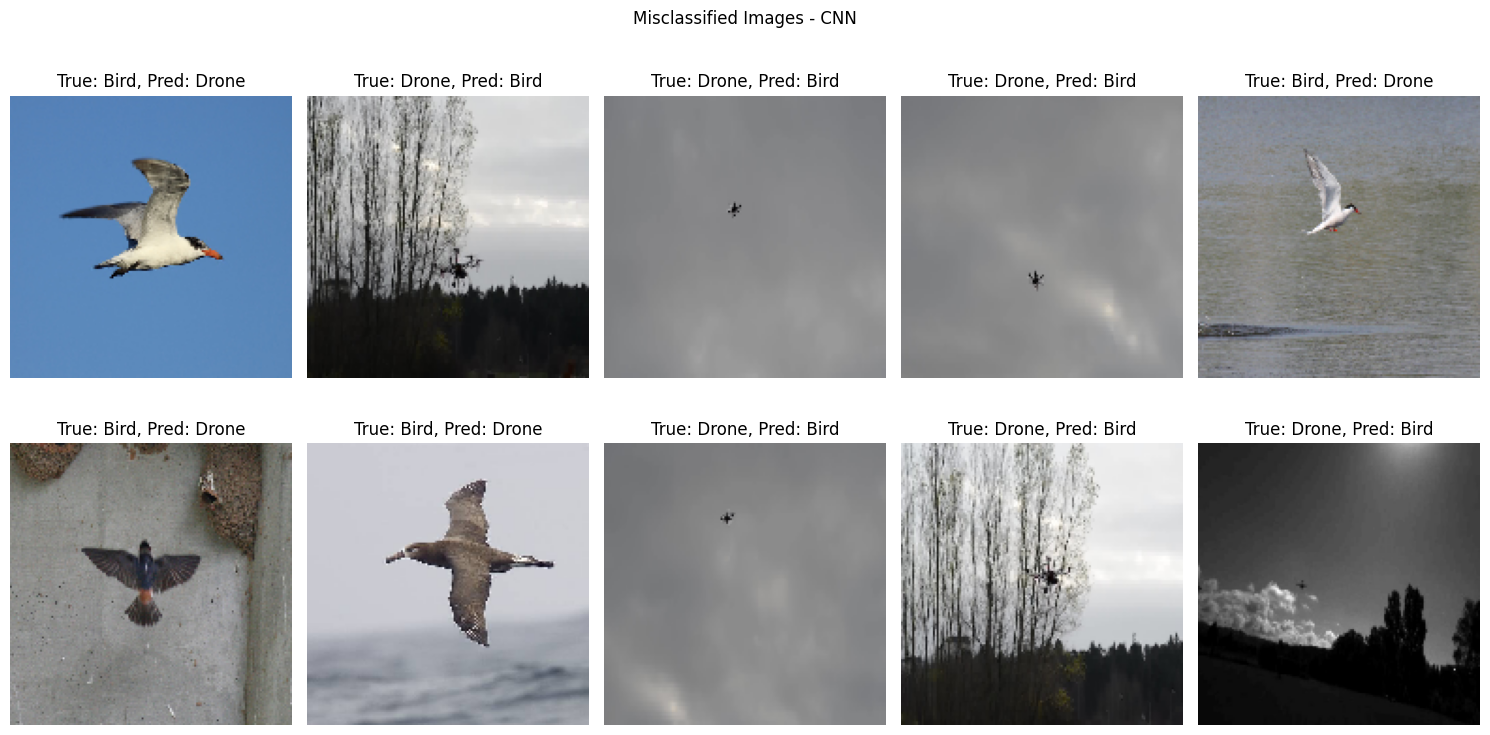

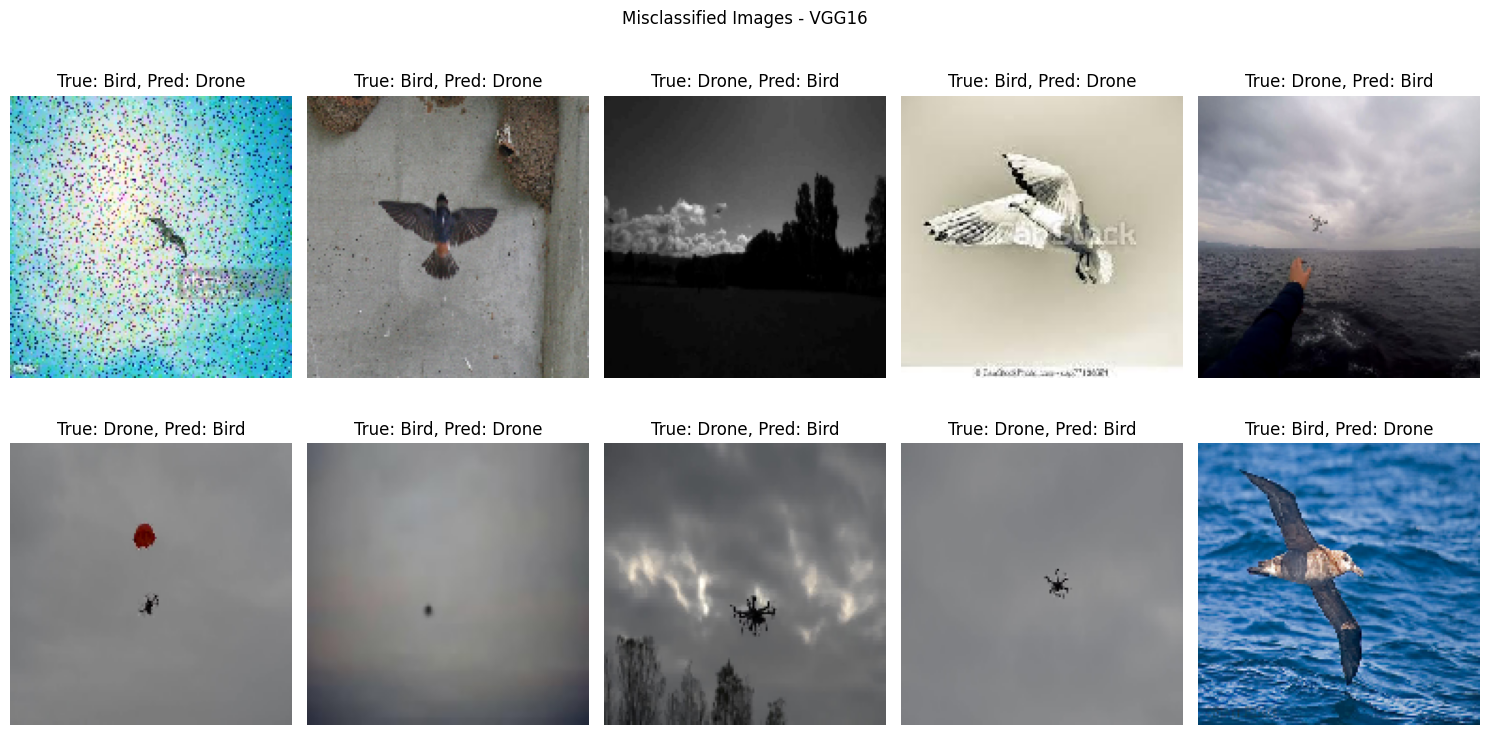

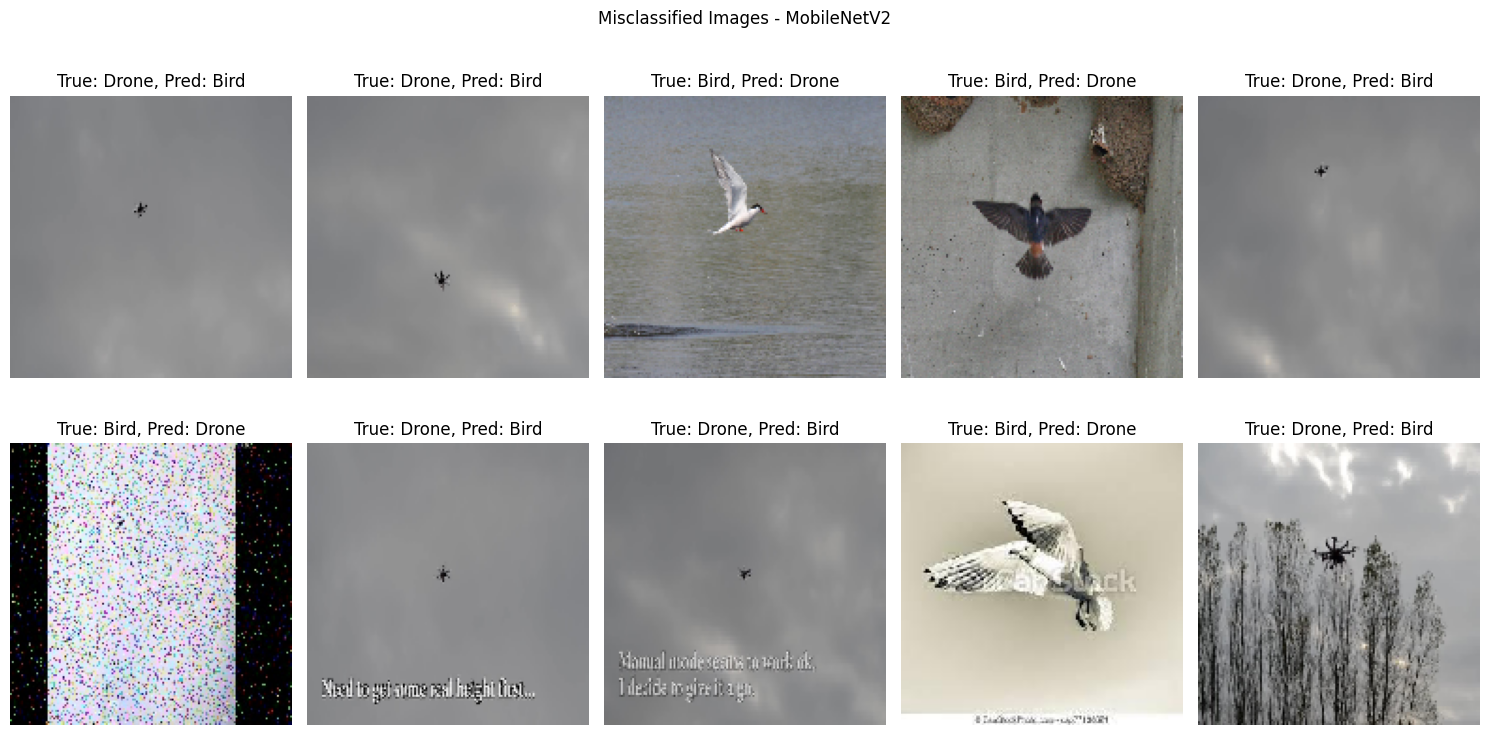

In [ ]:
#Step 11 - Displaying the misclassified Images by comparing all 3 models
from pydoc import classname


def show_misclassified(images, y_true, y_pred, class_names, model_name, max_images=10):
    misclassified_indices = np.where(y_true != y_pred)[0]
    plt.figure(figsize=(15, 8))

    for i, idx in enumerate(misclassified_indices[:max_images]):
        plt.subplot(2, 5, i + 1)
        
        img = images[idx]

        # If image is normalized (e.g., values between 0 and 1), scale back to 0-255
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.title(f"True: {class_names[int(y_true[idx])]}, Pred: {class_names[int(y_pred[idx])]}")
        plt.axis('off')

    plt.suptitle(f"Misclassified Images - {model_name}")
    plt.tight_layout()
    plt.show()
class_names = ['Bird', 'Drone']

show_misclassified(all_images, y_true_label, y_predict_cnn, class_names, "CNN")
show_misclassified(all_images, y_true_label, y_predict_vgg, class_names, "VGG16")
show_misclassified(all_images, y_true_label, y_predict_mobilenet, class_names, "MobileNetV2")


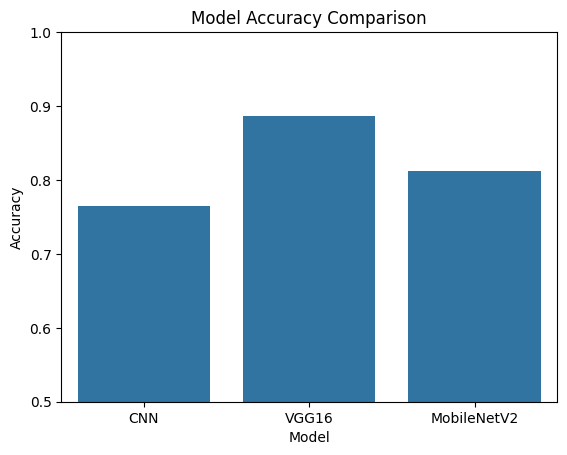

In [ ]:
#Step 12 - Accuracy comparison table for models
import pandas as pd

final_df = pd.DataFrame({
    'Model': ['CNN', 'VGG16', 'MobileNetV2'],
    'Accuracy': [
        round(accuracy_score(y_true_label, y_predict_cnn), 3),
        round(accuracy_score(y_true_label, y_predict_vgg), 3),
        round(accuracy_score(y_true_label, y_predict_mobilenet), 3)
    ]
})

sns.barplot(x='Model', y='Accuracy', data=final_df)
plt.title("Model Accuracy Comparison")
plt.ylim(0.5, 1.0)
plt.show()


### Final Insights:
- Among the three models tested, **VGG16** outperformed both CNN and MobileNetV2 with the highest accuracy, indicating its strong feature extraction capabilities with the accuracy of 0.8865853658536585.
- **MobileNetV2** achieved better accuracy than the basic CNN model, highlighting its efficiency as a lightweight, pre-trained architecture.
- The **CNN model**, though simpler, showed the lowest accuracy, reinforcing the advantage of using VGG16 and MobileNetV2 for improved performance.
